In [147]:
import pandas as pd
import numpy as np

df = pd.read_csv("../results/nifty_backtest_test_results.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5596 entries, 0 to 5595
Data columns (total 53 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              5596 non-null   datetime64[ns]
 1   spot_open             5596 non-null   float64       
 2   spot_high             5596 non-null   float64       
 3   spot_low              5596 non-null   float64       
 4   spot_close            5596 non-null   float64       
 5   spot_volume           5596 non-null   int64         
 6   fut_open              5596 non-null   float64       
 7   fut_high              5596 non-null   float64       
 8   fut_low               5596 non-null   float64       
 9   fut_close             5596 non-null   float64       
 10  fut_volume            5596 non-null   int64         
 11  opt_open              5596 non-null   float64       
 12  opt_high              5596 non-null   float64       
 13  opt_low           

In [148]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

joblib.dump(xgb_model, "../models/xgb_trade_filter.pkl")


['../models/xgb_trade_filter.pkl']

In [149]:
df["target"] = np.where(df["strategy_return"] > 0, 1, 0)


In [150]:
df_trades = df[df["trade_signal"] != 0].copy()

print("Total trades for ML:", len(df_trades))


Total trades for ML: 105


In [151]:
base_features = [
    "ema_5",
    "ema_15",
    "spot_return",
    "rolling_volatility",
    "avg_iv",
    "iv_spread",
    "futures_basis",
    "delta_neutral_ratio",
    "gamma_exposure",
]


In [152]:
df_trades["regime_code"] = df_trades["regime"].astype(int)


In [153]:
df_trades["hour"] = df_trades["datetime"].dt.hour
df_trades["minute"] = df_trades["datetime"].dt.minute


In [154]:
df_trades["lag_return_1"] = df_trades["spot_return"].shift(1)
df_trades["lag_return_2"] = df_trades["spot_return"].shift(2)


In [155]:
df_trades["ema_gap"] = df_trades["ema_5"] - df_trades["ema_15"]


In [156]:
features = (
    base_features
    + ["regime_code", "hour", "minute"]
    + ["lag_return_1", "lag_return_2"]
    + ["ema_gap"]
)

df_trades = df_trades.dropna()

X = df_trades[features]
y = df_trades["target"]


In [157]:
split_idx = int(len(X) * 0.7)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [158]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [159]:
from sklearn.metrics import classification_report

xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, xgb_preds))


              precision    recall  f1-score   support

           0       0.77      0.95      0.85        21
           1       0.80      0.40      0.53        10

    accuracy                           0.77        31
   macro avg       0.78      0.68      0.69        31
weighted avg       0.78      0.77      0.75        31



In [160]:
SEQ_LEN = 10

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X.iloc[i-seq_len:i].values)
        y_seq.append(y.iloc[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, SEQ_LEN)


In [161]:
split_idx = int(len(X_seq) * 0.7)

X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]


In [162]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    X_train_seq,
    y_train_seq,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
2/2 [==============================] - 3s 507ms/step - loss: 0.7839 - accuracy: 0.3654 - val_loss: 0.7903 - val_accuracy: 0.2308
Epoch 2/10
2/2 [==============================] - 0s 37ms/step - loss: 0.7381 - accuracy: 0.4423 - val_loss: 0.7097 - val_accuracy: 0.3077
Epoch 3/10
2/2 [==============================] - 0s 39ms/step - loss: 0.6984 - accuracy: 0.4808 - val_loss: 0.6489 - val_accuracy: 0.9231
Epoch 4/10
2/2 [==============================] - 0s 34ms/step - loss: 0.6871 - accuracy: 0.5769 - val_loss: 0.5955 - val_accuracy: 0.7692
Epoch 5/10
2/2 [==============================] - 0s 33ms/step - loss: 0.6589 - accuracy: 0.5962 - val_loss: 0.5583 - val_accuracy: 0.7692
Epoch 6/10
2/2 [==============================] - 0s 36ms/step - loss: 0.6820 - accuracy: 0.5000 - val_loss: 0.5397 - val_accuracy: 0.7692
Epoch 7/10
2/2 [==============================] - 0s 38ms/step - loss: 0.6618 - accuracy: 0.6154 - val_loss: 0.5244 - val_accuracy: 0.7692
Epoch 8/10
2/2 [==========

In [163]:
lstm_probs = model.predict(X_test_seq).flatten()
lstm_preds = (lstm_probs > 0.5).astype(int)

print(classification_report(y_test_seq, lstm_preds))


1/1 [==============================] - 0s 402ms/step
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        18
           1       0.00      0.00      0.00        10

    accuracy                           0.64        28
   macro avg       0.32      0.50      0.39        28
weighted avg       0.41      0.64      0.50        28



C:\Users\user\klypto\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\klypto\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\klypto\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [164]:
N = len(lstm_probs)
test_trades = df_trades.iloc[split_idx : split_idx + N].copy()
xgb_probs_aligned = xgb_probs[:N]
test_trades["xgb_conf"] = xgb_probs_aligned
test_trades["lstm_conf"] = lstm_probs




In [165]:
test_trades["xgb_take_trade"] = test_trades["xgb_conf"] > 0.5
test_trades["lstm_take_trade"] = test_trades["lstm_conf"] > 0.5


In [166]:
baseline_return = test_trades["strategy_return"].sum()

xgb_return = test_trades.loc[
    test_trades["xgb_take_trade"], "strategy_return"
].sum()

lstm_return = test_trades.loc[
    test_trades["lstm_take_trade"], "strategy_return"
].sum()

print("Baseline Return:", baseline_return)
print("XGBoost Filtered Return:", xgb_return)
print("LSTM Filtered Return:", lstm_return)


Baseline Return: 0.0053094501354355
XGBoost Filtered Return: 0.0008271054281364
LSTM Filtered Return: 0.0


In [167]:
# Ensure hour exists
df_trades["hour"] = pd.to_datetime(df_trades["datetime"]).dt.hour

# Create PnL proxy if not present (VERY IMPORTANT)
# Use strategy_return or trade_change depending on your notebook
df_trades["pnl"] = df_trades["trade_change"]

# Z-score
df_trades["pnl_zscore"] = (
    (df_trades["pnl"] - df_trades["pnl"].mean()) /
    df_trades["pnl"].std()
)

# Define outliers
outliers = df_trades[df_trades["pnl_zscore"].abs() > 2]


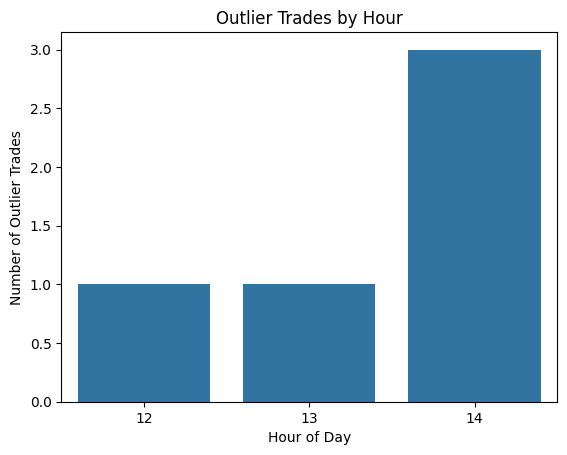

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="hour", data=outliers)
plt.title("Outlier Trades by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Outlier Trades")

plt.savefig("../plots/outlier_by_hour.png", dpi=150, bbox_inches="tight")
plt.show()


In [169]:
import pandas as pd

ml_summary = pd.DataFrame({
    "Model": ["Baseline", "XGBoost Filtered", "LSTM Filtered"],
    "Total_Return": [
        baseline_return,
        xgb_return,
        lstm_return
    ]
})

ml_summary.to_csv("../results/ml_return_comparison.csv", index=False)


In [170]:
model.save("../models/lstm_trade_filter")


INFO:tensorflow:Assets written to: ../models/lstm_trade_filter\assets


INFO:tensorflow:Assets written to: ../models/lstm_trade_filter\assets
